# Data Disentangling - PureGraph Size Comparison

Load the necessary packages and modules.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import linregress

sns.set_theme('paper',font_scale=1.5)
sns.set_style('white')

from modules.disentangling_contributions import \
    create_outline,interpolate_grid_scipy,plot_interpolated_contour,\
        equation_1_Gd_inv,equation_1_Ga_inv,equation_c1,equation_1_Gd,equation_1_Ga,\
        L_a_sim,L_D_sim

## Import Data

Import the .csv from (2)

In [2]:
data_dir = Path.cwd().joinpath('data')
data = pd.read_csv(data_dir.joinpath('input','puregraph_size_comparison_cleaned.csv')).iloc[:,1:]
data['ADGc'] = data['Par_DG_ADG'] * 2.3305**4

## Disentangling Contributions from 0D and 1D Defects

In [3]:
def match_outline(x):
    
    outline_lD = equation_1_Gd_inv(x+(15.0001-x.min()))
    outline_la = equation_1_Ga_inv(x+(15.0001-x.min()))

    outline_lD_len = len(outline_lD)
    outline_la_len = len(outline_la)
    
    generic = np.ones(outline_lD_len) * 500
    
    L_a = np.append(generic,outline_la)
    L_D = np.append(outline_lD,generic)
    line_type = ['dashed'] * outline_lD_len + ['solid'] * outline_lD_len
    
    data            = pd.DataFrame({'LA':L_a,'LD':L_D})
    data['Gd']      = data['LD'].apply(equation_1_Gd)
    data['Ga']      = data['LA'].apply(equation_1_Ga)
    data['y']       = data.apply(lambda x: equation_c1(x.LA,x.LD), axis=1)
    data['type']    = line_type
    
    return data

def envelope_contour(df):
    
    xin = df.columns
    
    outline_match = match_outline(xin)
    
    dashed_columns = outline_match.loc[outline_match['type'] == 'dashed','y'].values
    df.columns = dashed_columns
    df = df.apply(lambda x: x[x.index < x.name] ,axis=0)
    
    solid_columns = outline_match.loc[outline_match['type'] == 'solid','y']
    df.columns = solid_columns 
    df = df.apply(lambda x: x[x.index > x.name] ,axis=0)
    
    df.columns = xin
    
    return df

def translate_points(x,y,df):
    
    xr = round(x,2)
    yr = round(y,2)
        
    lookup = np.nan
    
    if xr in df.columns:
        if yr in df.index:
            lookup = df.loc[yr,xr]

    
    return lookup

In [4]:
xa, ya, za = interpolate_grid_scipy(L_a_sim,'La')
xd, yd, zd = interpolate_grid_scipy(L_D_sim,'Ld')

In [5]:
df_La       = pd.DataFrame(za, index = ya, columns=xa)
df_La_Env   = envelope_contour(df_La)

In [6]:
df_LD       = pd.DataFrame(zd, index = yd, columns=xd)
df_LD_Env   = envelope_contour(df_LD)

In [7]:
df_LD_Env.columns   = np.round(df_LD_Env.columns,2)
df_LD_Env.index     = np.round(df_LD_Env.index,2)
df_La_Env.columns   = np.round(df_La_Env.columns,2)
df_La_Env.index     = np.round(df_La_Env.index,2)

In [8]:
data['La']      = data.apply(lambda g: translate_points(g.Par_G_fwhm,g.ADGc,df_La_Env),axis=1).dropna()
data['LD']      = data.apply(lambda g: translate_points(g.Par_G_fwhm,g.ADGc,df_LD_Env),axis=1).dropna()
data['sigma']   = 1 / (data['LD']**2) 
data['La2']     = (data['La']**2)

In [9]:
data_m = data.groupby(['material','functionalisation'])[['Par_G_fwhm','ADGc','sigma','La2']].agg([np.mean,np.std]).reset_index(drop=False)
data_m.columns = data_m.columns.get_level_values(0)
data_m.columns = [
    'material',
    'functionalisation',
    'Par_G_fwhm_mean',
    'Par_G_fwhm_std',
    'ADGc_fwhm_mean',
    'ADGc_fwhm_std',
    'sigma_mean',
    'sigma_std',
    'La2_mean',
    'La2_std',
    ]
data_m

,material,functionalisation,Par_G_fwhm_mean,Par_G_fwhm_std,ADGc_fwhm_mean,ADGc_fwhm_std,sigma_mean,sigma_std,La2_mean,La2_std
0,PG10,BL,32.146239,3.626069,24.433406,4.475043,0.003687,0.001743,730.729679,273.551936
1,PG20,BL,28.840044,2.902611,19.390550,5.356395,0.002404,0.001560,1086.347129,676.464019
2,PG5,BL,37.807192,5.227234,27.280173,4.023186,0.004427,0.001861,500.148937,189.184401


## Plot

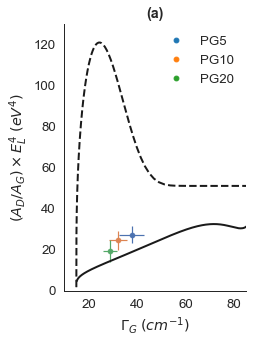

In [10]:
graph = sns.FacetGrid(
    data=data_m,
    hue= 'material',
    hue_order = ['PG5','PG10','PG20'],
    height = 5,
    aspect = 3/4,
    legend_out=False,
)

graph.map_dataframe(
    plt.errorbar,
    x = 'Par_G_fwhm_mean',
    y = 'ADGc_fwhm_mean',
    yerr = 'ADGc_fwhm_std',
    xerr = 'Par_G_fwhm_std' ,
    
)

graph.map_dataframe(
    plt.scatter,
    x = 'Par_G_fwhm_mean',
    y = 'ADGc_fwhm_mean',
)

outline_data = create_outline()

graph.set(xlim=(10,85),ylim=(0,130))

plt.grid(False)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'dashed'],x='Gd',y='y',ls='--',ax=graph.axes.flatten()[0],color='k',lw=2)
sns.lineplot(data=outline_data.loc[outline_data['type'] == 'solid'], x='Ga',y='y',ax=graph.axes.flatten()[0],color='k',lw=2)

plt.xlabel(r'$\Gamma _G$ $(cm^{-1})$')
plt.ylabel(r'$(A_D/A_G) \times E_L^4$ $(eV^4)$')
plt.title('(a)',fontweight='bold')
plt.legend('')

custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=0,label='PG5',marker='o'),
    Line2D([0], [0], color='tab:orange', lw=0,label = 'PG10',marker='o'),
    Line2D([0], [0], color='tab:green', lw=0,label = 'PG20',marker='o'),
                ]

plt.legend(handles= custom_lines,frameon=False)
plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 5 (a).png'),dpi=300)

plt.show()

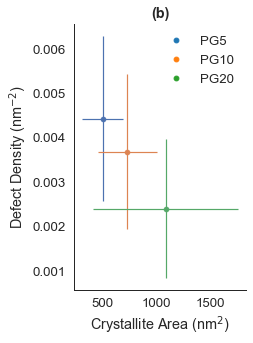

In [11]:
graph = sns.FacetGrid(
    data=data_m,
    hue= 'material',
    hue_order = ['PG5','PG10','PG20'],
    height = 5,
    aspect = 3/4,
    legend_out=False,
)

graph.map_dataframe(
    plt.errorbar,
    x = 'La2_mean',
    y = 'sigma_mean',
    yerr = 'sigma_std',
    xerr = 'La2_std' ,
)

graph.map_dataframe(
    plt.scatter,
    x = 'La2_mean',
    y = 'sigma_mean',
)

plt.xlabel(r'Crystallite Area (nm$^2$)')
plt.ylabel(r'Defect Density (nm$^{-2}$)')
plt.title('(b)',fontweight='bold')

custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=0,label='PG5',marker='o'),
    Line2D([0], [0], color='tab:orange', lw=0,label = 'PG10',marker='o'),
    Line2D([0], [0], color='tab:green', lw=0,label = 'PG20',marker='o'),
                ]

plt.legend(handles= custom_lines,frameon=False)
plt.grid(False)
plt.tight_layout()

plt.savefig(Path.cwd().joinpath('figures','Figure 5 (b).png'),dpi=300)
plt.show()


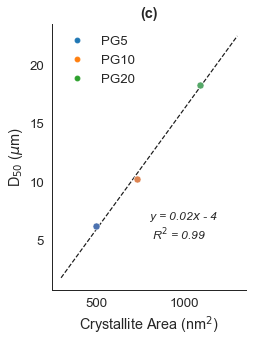

In [12]:
data_m['D50'] = pd.Series([10.2,18.3,6.22])
data_m['D50_std'] = pd.Series([1.459132,1.459132,1.155052])

graph = sns.FacetGrid(
    data=data_m,
    hue= 'material',
    hue_order = ['PG5','PG10','PG20','PG50'],
    height = 5,
    aspect = 3/4,
    legend_out=False,
)

y = data_m['D50']
x = data_m['La2_mean']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

def plot_error(*args,**kwargs):
    data = kwargs.pop('data')
    plt.errorbar(
        y = data['D50'],
        x = data['La2_mean'],
        yerr  = data['D50_std'],
        xerr = data['La2_std'],
        **kwargs
    )

    
graph.map_dataframe(
    sns.scatterplot,
    'La2_mean',
    'D50',
    s=50,
)

plt.plot(np.arange(300,1300),slope*np.arange(300,1300)+intercept,
         c = 'k',
         ls = '--',
         zorder=0)

custom_lines = [
    Line2D([0], [0], color='tab:blue', lw=0,label='PG5',marker='o'),
    Line2D([0], [0], color='tab:orange', lw=0,label = 'PG10',marker='o'),
    Line2D([0], [0], color='tab:green', lw=0,label = 'PG20',marker='o'),
                ]

plt.legend(handles= custom_lines,frameon=False, loc='upper left')

plt.annotate(
    f'y = {slope:.2f}$x$ - {-1*intercept:.0f} \n R$^2$ = {r_value**2:.2f}',
    (800,5),
    fontstyle='italic',
    fontsize=12
)

plt.xlabel(r'Crystallite Area (nm$^2$)')
plt.ylabel(r'D$_{50}$ ($\mu$m)')
plt.title('(c)', fontweight='bold')

plt.tight_layout()
plt.savefig(Path.cwd().joinpath('figures','Figure 5 (c).png'),dpi=300)
plt.show()

## Export Data

In [13]:
data.to_csv(
    Path.cwd().joinpath(
        'data',
        'output',
        'puregraph_size_comparison_disentangled.csv')
)